In [1]:
from pathlib import Path

import autochem as ac
import automech
import automol
import more_itertools as mit
import numpy as np
from project_utilities import p_
from protomech import mess

T_range = (300, 1200)
T_vals = (600, 700, 800, 900, 1000, 1100, 1200)
P_vals = (0.1, 1, 10, 100)
T_drop = (300, 400)  # Drop low-T rates for fit
A_fill = 1e-20
compare = False

stoich = "C5H7"
clear_nodes = []
clear_edges = []

# stoich = "C5H7O2"
# clear_nodes = []  # was clearing: ["C5H6O(645)z+OH(4)", "CPND2(626)+OH(4)"]
# clear_edges = []

# stoich = "C5H9"
# clear_nodes = []
# clear_edges = []

# stoich = "C5H9O"
# clear_nodes = []
# clear_edges = []

# stoich = "C5H9O2"
# clear_nodes = []
# clear_edges = [
#     # Well-skipping:
#     ("C5H8O(833)+OH(4)", "C5H8O(829)rs+OH(4)")
# ]

# stoich = "C5H11O"  # suspicious -- doesn't seem to compare well with theory
# clear_nodes = []
# clear_edges = []

# stoich = "C5H11O2"
# clear_nodes = []
# clear_edges = []

tag = "Z_mess_v0"
root_path = Path("../..")
stoich_path = Path(stoich)

In [2]:
mech = automech.io.read(p_.stereo_mechanism(tag, "json", p_.data(root_path)))
mech.reactions = automech.reaction.select_pes(mech.reactions, stoich)
mech = automech.without_unused_species(mech)

In [3]:
mess_inp = stoich_path / "mess.inp"
surf = mess.surf.from_mess_input(mess_inp)

In [4]:
mess_out = stoich_path / "rate.out"
surf = mess.surf.with_mess_output_rates(surf, mess_out=mess_out)
surf = mess.surf.absorb_fake_nodes(surf)
surf_out = mess.surf.enforce_equal_enantiomer_rates(surf, tol=0.1)
mess.net.display(surf_out, mech=mech, height="1000px")

In [6]:
clear_node_keys = [
    mess.surf.node_key_from_label(surf_out, label) for label in clear_nodes
]
clear_edge_keys = [
    mess.surf.edge_key_from_labels(surf_out, labels) for labels in clear_edges
]

print(f"clearing out rates for nodes {clear_node_keys}")
surf_out = mess.surf.clear_node_rates(surf_out, keys=clear_node_keys)

print(f"clearing out rates for edges {clear_edge_keys}")
surf_out = mess.surf.clear_edge_rates(surf_out, keys=clear_edge_keys)

clearing out rates for nodes []
clearing out rates for edges []


In [7]:
print("Clearing unfittable pressure ranges.")
surf_out = mess.surf.clear_unfittable_pressure_ranges(surf_out)

Clearing unfittable pressure ranges.


In [8]:
unfit_skip_rate_keys = mess.surf.unfittable_rate_keys(surf_out, direct=False)
print(f"Dropping completely unfittable well-skipping rates:\n{unfit_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, unfit_skip_rate_keys)

Dropping completely unfittable well-skipping rates:
[(0, 4), (4, 0)]


In [9]:
surf_out = mess.surf.remove_isolates(surf_out)
irrel_skip_rate_keys = mess.surf.irrelevant_rate_keys(
    surf_out, T=T_vals, P=P_vals, direct=False, min_branch_frac=0.01
)
print(f"Dropping irrelevant well-skipping rates:\n{irrel_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, irrel_skip_rate_keys)

Dropping irrelevant well-skipping rates:
[(0, 3), (0, 5), (3, 0), (4, 2), (5, 0), (5, 3), (5, 2), (6, 0)]


In [10]:
bad_skip_rate_keys = mess.surf.bad_pressure_independence_rate_keys(
    surf_out, T_vals=T_vals, direct=False
)
print(f"Dropping bad pressure-independent well-skipping rates:\n{bad_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, bad_skip_rate_keys)

Dropping bad pressure-independent well-skipping rates:
[]


In [11]:
unfit_rate_keys = mess.surf.unfittable_rate_keys(surf_out, well_skipping=False)
print(f"Clearing completely unfittable direct rates:\n{unfit_rate_keys}")

surf_out = mess.surf.clear_rates(surf_out, unfit_rate_keys)

Clearing completely unfittable direct rates:
[]


In [12]:
punfit_rate_keys = mess.surf.bad_pressure_independence_rate_keys(
    surf_out, T_vals=T_vals, well_skipping=False, empty=False
)
print(
    f"Clearing partially-unfittable pressure-independent direct rates:\n{punfit_rate_keys}"
)

surf_out = mess.surf.clear_rates(surf_out, punfit_rate_keys)

Clearing partially-unfittable pressure-independent direct rates:
[]


In [13]:
# Identifying branching fractions as well as
print("Calculating branching fractions.")
branch_frac_dct = mess.surf.branching_fractions(surf_out, T=T_vals, P=P_vals)

print("Determining irrelevant pressures.")
irrel_pressure_dct = mess.surf.irrelevant_rate_pressures(
    surf_out, T=T_vals, P=P_vals, min_branch_frac=0.01
)
print(irrel_pressure_dct)

Calculating branching fractions.
Determining irrelevant pressures.
{(0, 2): [], (2, 0): [], (2, 3): [], (2, 6): [100.0], (3, 4): [], (3, 6): [100.0], (3, 2): [], (4, 3): [0.1], (4, 5): [], (4, 6): [], (5, 4): [], (5, 6): [], (6, 3): [1.0, 100.0], (6, 4): [10.0, 100.0], (6, 5): [], (6, 2): [1.0, 100.0]}


In [14]:
print("Matching rates to reaction directions.")
surf_out = mess.surf.match_rate_directions(surf_out, mech)

Matching rates to reaction directions.


In [15]:
surf_out = mess.surf.fit_rates(
    surf_out,
    T_drop=T_drop,
    A_fill=A_fill,
    bad_fit="raise",
    bad_fit_fill_pressures_dct=irrel_pressure_dct,
)

/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=3260827697053.372 b=0.4583792664360522 E=44184.18856777419 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=19.272931624407217 b=3.5946391559452913 E=41164.446878598654 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=135989643668.2293 b=0.7805663772583085 E=44687.146129886234 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)


Direct rates:
(0, 2) C5H7(487)z = C2H2(40) + C3H5(122)


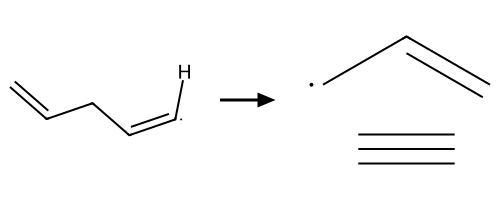

alt.LayerChart(...)

Median branching fraction: 1.0
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]

(3, 2) C5H7(487)e = C2H2(40) + C3H5(122)


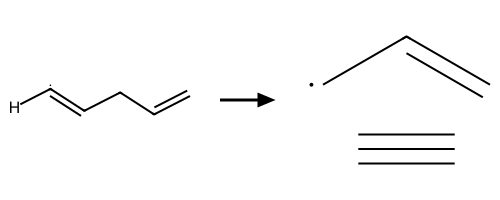

alt.LayerChart(...)

Median branching fraction: 0.059871472822995084
[[3.81555991e-04 1.59768639e-03 2.31189302e-03 2.43659983e-03]
 [1.74129778e-03 8.24497619e-03 1.36063678e-02 1.49586710e-02]
 [5.47370714e-03 2.68920750e-02 4.91680152e-02 5.65375280e-02]
 [1.35635018e-02 6.46455640e-02 1.22819285e-01 1.47566548e-01]
 [3.02938042e-02 1.25080593e-01 2.33300100e-01 2.86726861e-01]
 [6.32054176e-02 2.07356208e-01 3.63073814e-01 4.39247171e-01]
 [1.21004566e-01 3.04347826e-01 4.89510490e-01 5.76653498e-01]]

(4, 3) C5H7(504) = C5H7(487)e


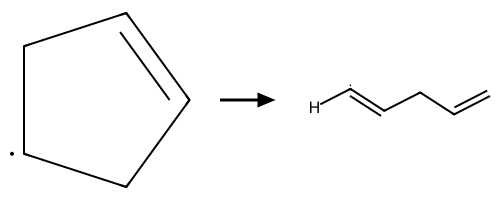

alt.LayerChart(...)

Median branching fraction: 0.00525456108525643
[[0.00029205        nan 0.00087835        nan]
 [0.00065407 0.0016027  0.00217812 0.00228538]
 [0.00103927 0.00300822 0.00493599 0.00557313]
 [0.00159309 0.00444982 0.00857605 0.01061459]
 [0.00251792 0.00601916 0.01220638 0.01693489]
 [0.00387999 0.00800659 0.01557415 0.02350202]
 [0.00570545 0.01058445 0.01866989 0.0297577 ]]

(5, 4) C5H7(500) = C5H7(504)


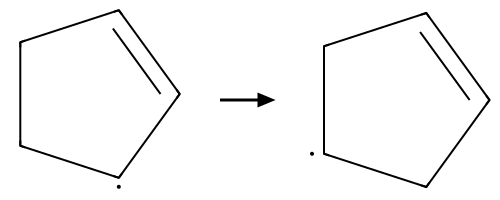

alt.LayerChart(...)

Median branching fraction: 0.1529112161843854
[[1.                nan 1.                nan]
 [1.         0.14629948 0.15030467 0.15065723]
 [0.12482066 0.14808462 0.1598916  0.16219119]
 [0.11511061 0.14576608 0.16848063 0.17569577]
 [0.1011236  0.1356674  0.17118644 0.18789809]
 [0.08868999 0.12157649 0.16648484 0.19577735]
 [0.07828585 0.10658307 0.1551652  0.19946631]]

(5, 6) C5H7(500) = C5H7(507)zz


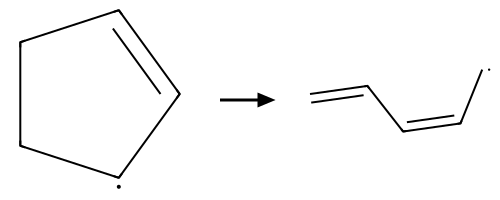

alt.LayerChart(...)

Median branching fraction: 0.8496953283683142
[[       nan        nan        nan        nan]
 [       nan 0.85370052 0.84969533 0.84934277]
 [0.87517934 0.85191538 0.8401084  0.83780881]
 [0.88488939 0.85423392 0.83151937 0.82430423]
 [0.8988764  0.8643326  0.82881356 0.81210191]
 [0.91131001 0.87842351 0.83351516 0.80422265]
 [0.92171415 0.89341693 0.8448348  0.80053369]]



In [16]:
label_dct = mess.surf.node_label_dict(surf_out)
obj_col = automech.util.df_.c_.temp()

print("Direct rates:")
for rate_key in mess.surf.rate_keys(
    surf_out, P_vals=[1.0], empty=False, well_skipping=False
):
    eq = mess.surf.edge_chemkin_equation(surf_out, rate_key)
    print(rate_key, eq)

    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]

    amchis = list(mit.unique_everseen(automech.reaction_amchis(mech, eq=eq)))
    for amchi in amchis:
        automol.amchi.display_reaction(*amchi)

    ref_rates = ref_labels = []
    if compare and amchis:
        ref_rates = [r.rate for r in automech.reaction_rate_objects(mech, eq)]
        ref_labels = [f"Ref {i}" for i, _ in enumerate(ref_rates)]

    display(
        ac.rate.data.display(
            [rate, rate_fit, *ref_rates],
            T_range=T_range,
            label=["Data", "Fit", *ref_labels],
            check_order=False,
        )
    )

    branch_frac_arr = branch_frac_dct[rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    print(f"Median branching fraction: {branch_frac}")
    print(branch_frac_arr)
    print()

In [17]:
print("Well-skipping rates:")
for rate_key in mess.surf.rate_keys(surf_out, direct=False):
    print(rate_key)
    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]
    display(
        ac.rate.data.display([rate, rate_fit], T_range=T_range, label=["Data", "Fit"])
    )

    branch_frac_arr = branch_frac_dct[rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    print(f"Median branching fraction: {branch_frac}")
    print(branch_frac_arr)
    print()

Well-skipping rates:
(3, 6)


alt.LayerChart(...)

Median branching fraction: 0.01794616151545364
[[2.97089398e-02 2.37630570e-03 6.07251450e-05 7.51355697e-07]
 [7.63951722e-02 1.05724326e-02 4.71903390e-04 7.75408661e-06]
 [1.50322704e-01 3.15286397e-02 2.31515536e-03 5.51993617e-05]
 [2.46609125e-01 7.04413732e-02 7.58431499e-03 2.69873957e-04]
 [3.76008525e-01 1.27014829e-01 1.79461615e-02 9.08265213e-04]
 [5.30474041e-01 1.95260430e-01 3.32765044e-02 2.23986968e-03]
 [           nan 2.64650284e-01 5.15734266e-02 4.39658468e-03]]

(4, 6)


alt.LayerChart(...)

Median branching fraction: 0.013334700994973844
[[           nan            nan            nan            nan]
 [           nan 3.61529569e-03 5.30709271e-04 5.75740409e-05]
 [2.93002580e-02 1.04734624e-02 2.02502069e-03 2.48544580e-04]
 [4.88408167e-02 2.26414248e-02 5.87009709e-03 8.50787992e-04]
 [6.98288429e-02 3.99230202e-02 1.33347010e-02 2.39080867e-03]
 [9.33502363e-02 6.18156129e-02 2.55695026e-02 5.66684238e-03]
 [1.22329546e-01 8.84055514e-02 4.31915289e-02 1.16443190e-02]]

(6, 2)


alt.LayerChart(...)

Median branching fraction: 5.404891863556358e-05
[[3.73725934e-02            nan 1.34376595e-02            nan]
 [           nan 3.91608958e-07 1.10114466e-08 3.71187335e-11]
 [1.68867037e-05 6.66922456e-06 3.96365562e-07 2.87917091e-09]
 [1.10534507e-04 5.40489186e-05 5.94413135e-06 8.63840352e-08]
 [5.09973083e-04 2.69796793e-04 4.70079012e-05 1.29255179e-06]
 [1.84203589e-03 9.76001215e-04 2.34032993e-04 1.13196582e-05]
 [5.68218981e-03 2.85709530e-03 8.31104438e-04 6.47211101e-05]]

